<a href="https://colab.research.google.com/github/Kennethfargose/Image-to-Text-/blob/main/img2text_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell,BatchNormalization
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

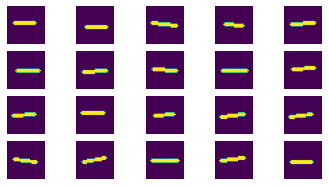

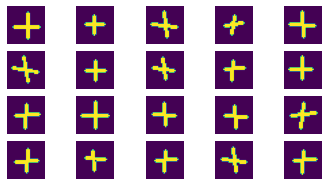

In [ ]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [ ]:
import random

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 44412

X_text: "111-  6" = y_text: " 105"


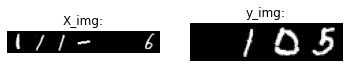

Sample ID: 33047

X_text: " 82+123" = y_text: " 205"


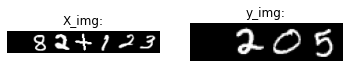

Sample ID: 51452

X_text: "128-126" = y_text: "   2"


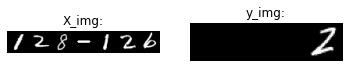

Sample ID: 66040

X_text: "165- 20" = y_text: " 145"


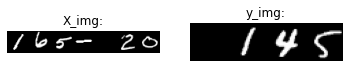

Sample ID: 45804

X_text: "114-102" = y_text: "  12"


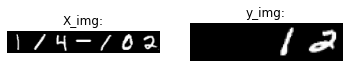

Sample ID: 65677

X_text: "164+ 38" = y_text: " 202"


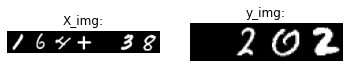

Sample ID: 35157

X_text: " 87+178" = y_text: " 265"


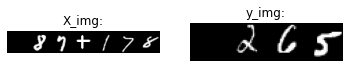

Sample ID: 63414

X_text: "158-107" = y_text: "  51"


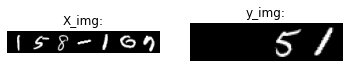

Sample ID: 21552

X_text: " 53-176" = y_text: "-123"


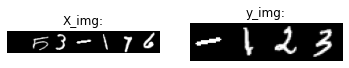

Sample ID: 64010

X_text: "160-  5" = y_text: " 155"


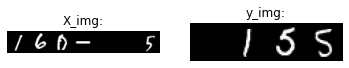

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(80000, 7, 13) (80000, 4, 13)


In [ ]:
(img_rows, img_cols) = X_img[0,0].shape
if K.image_data_format() == 'channels_first':
    X_img = X_img.reshape(X_img.shape[0], max_query_length,1, img_rows, img_cols)
    y_img = y_img.reshape(y_img.shape[0], max_answer_length,1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_img = X_img.reshape(X_img.shape[0], max_query_length, img_rows, img_cols, 1)
    y_img = y_img.reshape(y_img.shape[0], max_answer_length, img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
x_img_train,x_img_test,x_text_train,x_text_test,y_img_train,y_img_test,y_text_train,y_text_test=train_test_split(X_img,X_text_onehot,y_img,y_text_onehot,test_size=0.4)

# Image to text

In [ ]:
#cnn
i2t = tf.keras.Sequential()
i2t.add(Conv2D(32, 2, strides=(2,2),activation='relu',input_shape=input_shape))
i2t.add(Conv2D(64, (3, 3), strides=(2,2), activation='relu'))
i2t.add(BatchNormalization())
i2t.add(Conv2D(64, (3, 3), strides=(2,2), activation='relu'))
i2t.add(BatchNormalization())
i2t.add(Flatten())
i2t.add(Dense(128, activation='relu'))

i2t.add(Dense(len(unique_characters), activation='softmax'))
i2t.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#collect data for training and validating image2text
minus_samples=generate_images(cross=False,n=500)
plus_samples=generate_images(cross=True,n=500)
zeros_samples=np.zeros((500,28,28))
i2t_x=np.concatenate([MNIST_data,minus_samples,plus_samples,zeros_samples ],axis=0)
i2t_y=np.concatenate([MNIST_labels,['-']*500,['+']*500,[' ']*500 ],axis=0)
i2t_y_onehot = encode_labels(i2t_y)
i2t_y_onehot=i2t_y_onehot.reshape((-1,len(unique_characters)))


(img_rows, img_cols) = i2t_x[0].shape
if K.image_data_format() == 'channels_first':
    i2t_x = i2t_x.reshape(i2t_x.shape[0], 1, img_rows, img_cols)
    i2t_input_shape = (1, img_rows, img_cols)
else:
    i2t_x = i2t_x.reshape(i2t_x.shape[0], img_rows, img_cols, 1)
    i2t_input_shape = (img_rows, img_cols, 1)
print(i2t_x.shape,  i2t_y_onehot.shape)

i2t_x_train,i2t_x_test,i2t_y_train,i2t_y_test=train_test_split(i2t_x,i2t_y_onehot,test_size=0.5,shuffle=True)


(61500, 28, 28, 1) (61500, 13)


In [ ]:

i2t=i2t.fit(i2t_x_train,i2t_y_train,epochs=10,batch_size=1024,validation_data=(i2t_x_test,i2t_y_test))

Epoch 1/10
31/31 [==============================] - 7s 216ms/step - loss: 5530.5156 - accuracy: 0.0931 - val_loss: 12154.0508 - val_accuracy: 0.0957
Epoch 2/10
31/31 [==============================] - 5s 168ms/step - loss: 4609.2871 - accuracy: 0.0946 - val_loss: 6440.4771 - val_accuracy: 0.0944
Epoch 3/10
31/31 [==============================] - 5s 168ms/step - loss: 3765.5186 - accuracy: 0.0959 - val_loss: 4185.4658 - val_accuracy: 0.0939
Epoch 4/10
31/31 [==============================] - 5s 167ms/step - loss: 2973.3730 - accuracy: 0.0989 - val_loss: 2846.2744 - val_accuracy: 0.0950
Epoch 5/10
31/31 [==============================] - 5s 168ms/step - loss: 2237.2981 - accuracy: 0.1021 - val_loss: 1939.1420 - val_accuracy: 0.0976
Epoch 6/10
31/31 [==============================] - 5s 168ms/step - loss: 1614.2942 - accuracy: 0.1096 - val_loss: 1260.5626 - val_accuracy: 0.1054
Epoch 7/10
31/31 [==============================] - 5s 168ms/step - loss: 1100.6573 - accuracy: 0.1261 - val_lo

In [ ]:
from tensorflow.keras.layers import TimeDistributed

In [ ]:
#lstm
adam=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.89, beta_2=0.98)

#keras functional API
inputs = tf.keras.Input(shape=(7,28,28,1))
x = TimeDistributed(i2t)(inputs)
x = LSTM(256)(x)
x = BatchNormalization()(x)
x = RepeatVector(max_answer_length)(x)
x = LSTM(256, return_sequences=True)(x)
outputs = TimeDistributed(Dense(len(unique_characters), activation='softmax'))(x)

img2text = tf.keras.Model(inputs=inputs, outputs=outputs, name="img2text")
img2text.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:

#x/y are either text or one hot encoding
def display_data(n,X,y):
    print('='*50, '\nSample: ', n, '\n')
    if len(X.shape) == 5:
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title('Query:')
        plt.imshow(np.hstack(X[n,:,:,:,0]))
    else:
        query=''
        for char in X[n]:
            query+=str(unique_characters[np.where(char==1)[0][0]])
        print('query is:',query)
    if len(y.shape)==5:
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title('Answer:')
        plt.imshow(np.hstack(y[n,:,:,:,0]))
    else:
        answer=''
        for char in y[n]:
            answer+=str(unique_characters[np.where(char==1)[0][0]])
    plt.show()
    if len(y.shape)!=5:
        print('answer is:',answer)




In [ ]:
img2textfit=img2text.fit(x_img_train,y_text_train,epochs=300,validation_data=(x_img_test,y_text_test),batch_size=250)

Epoch 1/300
192/192 [==============================] - 85s 422ms/step - loss: 1.4138 - accuracy: 0.4197 - val_loss: 1.8283 - val_accuracy: 0.3592
Epoch 2/300
192/192 [==============================] - 79s 413ms/step - loss: 1.3385 - accuracy: 0.4331 - val_loss: 1.5554 - val_accuracy: 0.4123
Epoch 3/300
192/192 [==============================] - 78s 409ms/step - loss: 1.3382 - accuracy: 0.4340 - val_loss: 1.4302 - val_accuracy: 0.4308
Epoch 4/300
192/192 [==============================] - 78s 408ms/step - loss: 1.3329 - accuracy: 0.4355 - val_loss: 1.6345 - val_accuracy: 0.3929
Epoch 5/300
192/192 [==============================] - 78s 409ms/step - loss: 1.3341 - accuracy: 0.4343 - val_loss: 2.2592 - val_accuracy: 0.3843
Epoch 6/300
192/192 [==============================] - 78s 406ms/step - loss: 1.3207 - accuracy: 0.4570 - val_loss: 1.3177 - val_accuracy: 0.4642
Epoch 7/300
192/192 [==============================] - 77s 402ms/step - loss: 1.2876 - accuracy: 0.4843 - val_loss: 1.3042 -

In [ ]:
font = {'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

def plot(history,ylim=None,path=None):
    plt.figure(figsize=(20,10))
    for key in history.history.keys():
        plt.plot(history.history[key])

    plt.legend(history.history.keys())
    plt.ylim(ylim)
    plt.ylabel('accuracy and loss')
    plt.xlabel('epochs')
    plt.grid(True)
    if path:
        plt.savefig(path)

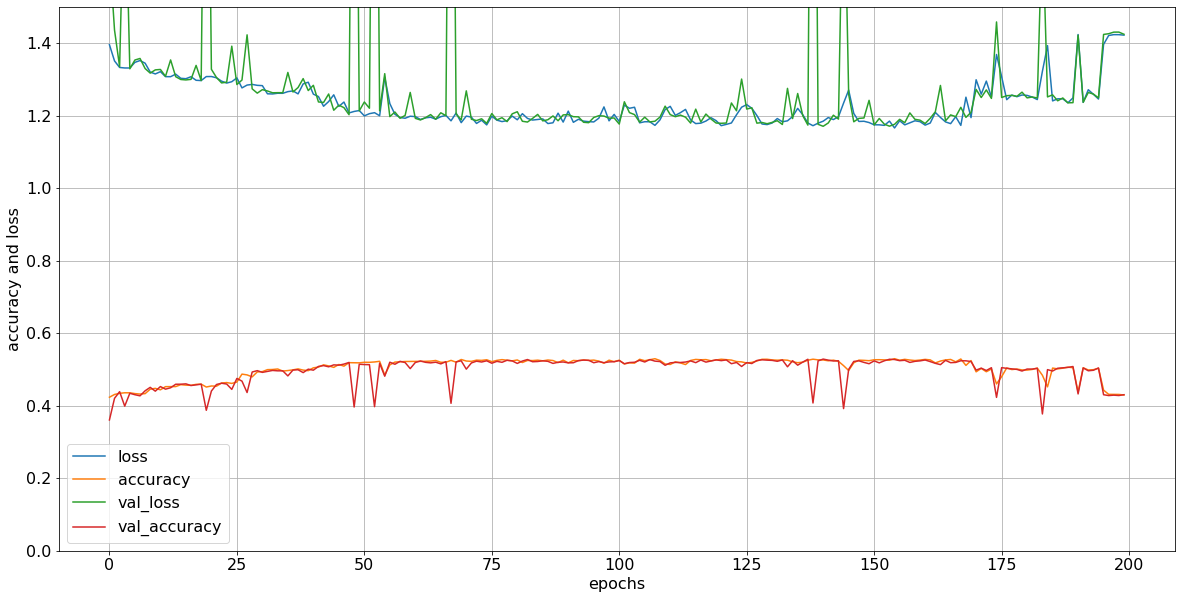

In [ ]:
plot(img2textfit,ylim=[0,1.5],path='training_img2text.png')
